In [740]:
# Fix the SVG content by declaring the 'inkscape' namespace properly
# Read the SVG content from file
with open('data/level5.svg', 'r') as file:
    svg_content = file.read()

In [741]:
# Parse SVG and extract elements
from xml.etree import ElementTree as ET

ns = {'svg': 'http://www.w3.org/2000/svg', 'inkscape': 'http://www.inkscape.org/namespaces/inkscape'}

tree = ET.ElementTree(ET.fromstring(svg_content))
root = tree.getroot()

In [742]:
def parse_rect_with_rotation(elem):
    x = float(elem.attrib.get("x", 0))
    y = float(elem.attrib.get("y", 0))
    w = float(elem.attrib.get("width", 0))
    h = float(elem.attrib.get("height", 0))

    # Build basic rectangle
    poly = Polygon([
        (x, y), (x + w, y),
        (x + w, y + h), (x, y + h)
    ])

    # Parse transform if exists
    transform = elem.attrib.get("transform", "")
    if "rotate" in transform:
        match = re.search(r'rotate\(([-+]?[0-9]*\.?[0-9]+)\)', transform)
        if match:
            angle = float(match.group(1))
            rotated_poly = poly  # rotate(poly, angle, use_radians=False)
            return rotated_poly

    return poly

In [743]:
def parse_path(d_attr):
    commands = re.findall(r'([MLHVZmlhvz])([^MLHVZmlhvz]*)', d_attr)
    vertices = []
    current_pos = (0.0, 0.0)
    start_point = None

    for cmd, args in commands:
        args = [float(n) for n in re.findall(r'[-+]?[0-9]*\.?[0-9]+', args)]
        is_relative = cmd.islower()
        cmd = cmd.upper()

        if cmd == 'M':
            for i in range(0, len(args), 2):
                x, y = args[i], args[i + 1]
                if is_relative:
                    x += current_pos[0]
                    y += current_pos[1]
                current_pos = (x, y)
                vertices.append(current_pos)
                if start_point is None:
                    start_point = current_pos

        elif cmd == 'L':
            for i in range(0, len(args), 2):
                x, y = args[i], args[i + 1]
                if is_relative:
                    x += current_pos[0]
                    y += current_pos[1]
                current_pos = (x, y)
                vertices.append(current_pos)

        elif cmd == 'H':
            for x in args:
                if is_relative:
                    x += current_pos[0]
                current_pos = (x, current_pos[1])
                vertices.append(current_pos)

        elif cmd == 'V':
            for y in args:
                if is_relative:
                    y += current_pos[1]
                current_pos = (current_pos[0], y)
                vertices.append(current_pos)

        elif cmd == 'Z':
            if start_point and current_pos != start_point:
                vertices.append(start_point)
            current_pos = start_point

    if len(vertices) >= 3:
        poly = Polygon(vertices)
        return poly if poly.is_valid else None
        return None


In [744]:
from shapely.geometry import Point, Polygon


# Helper to extract desk points
def extract_floor_plan(svg_root):
    for g in svg_root.findall(".//svg:g[@inkscape:label='floor_layer']", ns):
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            if polygon:
                return polygon
    return None


In [745]:
# Helper to extract desk points
def extract_desks(svg_root):
    desks = []
    for g in svg_root.findall(".//svg:g[@inkscape:label='desk_layer']", ns):
        for c in g.findall(".//svg:circle", ns):
            cx = float(c.attrib.get("cx"))
            cy = float(c.attrib.get("cy"))
            r = float(c.attrib.get("r"))
            desk_id = c.attrib.get(f"{{{ns['inkscape']}}}label", None)
            points = [
                (cx - r, cy - r),  # top left
                (cx + r, cy - r),  # top right
                (cx + r, cy + r),  # bottom right
                (cx - r, cy + r),  # bottom left
                (cx - r, cy - r)  # close the polygon by repeating first point
            ]
            desks.append((Polygon(points), desk_id))  # Return tuple of (polygon, id)
        for r in g.findall(".//svg:rect", ns):
            desk_poly = parse_rect_with_rotation(r)
            desk_id = c.attrib.get(f"{{{ns['inkscape']}}}label", None)
            desks.append((desk_poly, desk_id))  # Return tuple of (polygon, id)
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            desk_id = c.attrib.get(f"{{{ns['inkscape']}}}label", None)
            if polygon:
                desks.append((polygon, desk_id))  # Return tuple of (polygon, id)
    return desks


In [746]:
from shapely.geometry import Polygon
import re
from shapely.ops import unary_union


def extract_obstacles_with_full_path_support(svg_root):
    obstacles = []
    for g in svg_root.findall(".//svg:g[@inkscape:label='obstacle_layer']", ns):
        for path in g.findall(".//svg:path", ns):
            d_attr = path.attrib.get("d", "")
            polygon = parse_path(d_attr)
            if polygon:
                obstacles.append(polygon)

    if obstacles:
        merged_obstacles = unary_union(obstacles)
        if merged_obstacles.geom_type == 'Polygon':
            return [merged_obstacles]
        elif merged_obstacles.geom_type == 'MultiPolygon':
            return list(merged_obstacles.geoms)

    return obstacles

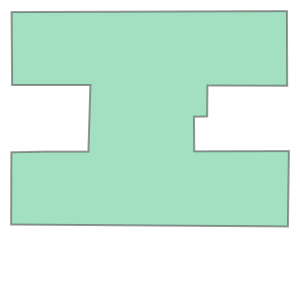

In [747]:
floor = extract_floor_plan(root)
floor

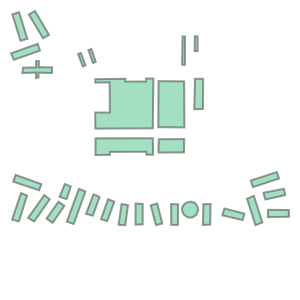

In [748]:
# Extract obstacle data
obstacles = extract_obstacles_with_full_path_support(root)
unary_union(obstacles)

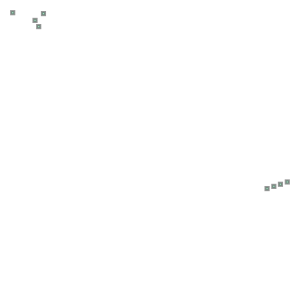

In [749]:
# Extract desk data
desks = extract_desks(root)
desk_polygons = [desk[0] for desk in desks]
unary_union(desk_polygons)

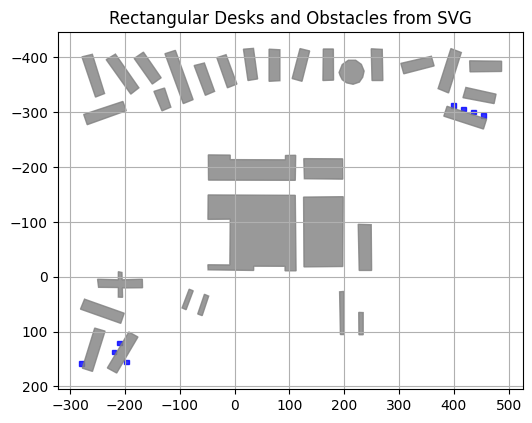

In [750]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

for desk, desk_id in desks:
    x, y = desk.exterior.xy
    ax.fill(x, y, color='blue', alpha=0.8)

for poly in obstacles:
    x, y = poly.exterior.xy
    ax.fill(x, y, color='gray', alpha=0.8)

ax.set_title("Rectangular Desks and Obstacles from SVG")
ax.set_aspect('equal')
ax.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [751]:
import math


def calculate_adaptive_grid_size(floor, max_grid_divisions=50):
    """
    Calculate a suitable grid size based on the floor dimensions,
    aiming to divide the floor into a specified maximum number of grid units.

    Args:
        floor (Polygon): The floor polygon.
        max_grid_divisions (int): Maximum number of grid cells along the longest dimension of the floor.

    Returns:
        float: A suitable grid size.
    """
    minx, miny, maxx, maxy = floor.bounds
    width = maxx - minx
    height = maxy - miny
    max_dimension = max(width, height)
    return math.ceil(max_dimension / max_grid_divisions)

In [752]:

def generate_walkability_graph(floor, desks, obstacles, padding=1, desk_edge_cost_multiplier=5):
    """
    Generate nodes and edges for a walkability graph based on floor plan, desks, and obstacles.
    Edges connected to desk centroids have a higher cost.
    """
    from shapely.geometry import Point, LineString
    from shapely.strtree import STRtree
    import numpy as np

    grid_size = calculate_adaptive_grid_size(floor)

    # Convert desks to just polygons for processing
    desk_polygons = [desk[0] for desk in desks]

    # Create spatial indexes
    obstacle_index = STRtree(obstacles)
    desk_index = STRtree(desk_polygons)

    # Get bounds of the floor
    minx, miny, maxx, maxy = floor.bounds

    # Generate grid points more efficiently
    x_coords = np.arange(float(minx), float(maxx), float(grid_size))
    y_coords = np.arange(float(miny), float(maxy), float(grid_size))
    X, Y = np.meshgrid(x_coords, y_coords)
    points = [Point(float(x), float(y)) for x, y in zip(X.flatten(), Y.flatten())]

    # Filter points more efficiently
    nodes = []
    for point in points:
        if not floor.contains(point):
            continue

        # Use spatial index for faster querying
        nearby_obstacle_idx = obstacle_index.query(point.buffer(padding))
        if any(obstacles[i].distance(point) < padding for i in nearby_obstacle_idx):
            continue

        nearby_desk_idx = desk_index.query(point.buffer(padding))
        if any(desk_polygons[i].distance(point) < padding for i in nearby_desk_idx):
            continue

        nodes.append(point)

    # Add desk centroids as nodes
    desk_nodes = []
    for desk, _ in desks:
        centroid = Point(desk.centroid)
        desk_nodes.append(centroid)
        nodes.append(centroid)

    # Generate edges more efficiently with costs
    edges = {}  # Use dict to store edges with their costs

    # Create spatial index for nodes
    node_index = STRtree(nodes)

    for i, node1 in enumerate(nodes):
        # Use spatial index to find nearby nodes
        search_radius = grid_size * 4.0 if node1 in desk_nodes else grid_size * 1.5
        nearby_node_idx = node_index.query(node1.buffer(search_radius))

        for idx in nearby_node_idx:
            node2 = nodes[idx]
            if node1 is node2:
                continue

            if node1 in desk_nodes and node2 in desk_nodes:
                continue

            # Create edge key in sorted order to avoid duplicates
            edge_key = tuple(sorted([(node1.x, node1.y), (node2.x, node2.y)]))
            if edge_key in edges:
                continue

            line = LineString([node1, node2])

            # Use spatial index for intersection checks
            obstacle_idx = obstacle_index.query(line)
            if any(obstacles[i].intersects(line) for i in obstacle_idx):
                continue

            # For non-desk connections, check desk intersections
            if node1 not in desk_nodes and node2 not in desk_nodes:
                desk_idx = desk_index.query(line)
                if any(desk_polygons[i].intersects(line) for i in desk_idx):
                    continue

            # Calculate base cost (distance)
            base_cost = node1.distance(node2)

            # Apply higher cost if either node is a desk centroid
            if node1 in desk_nodes or node2 in desk_nodes:
                cost = base_cost * desk_edge_cost_multiplier
            else:
                cost = base_cost

            edges[edge_key] = (node1, node2, cost)

    # Convert edges back to the original format with costs
    final_edges = [(start, end, cost) for (_, _), (start, end, cost) in edges.items()]

    # Ensure desk connectivity
    for desk_node in desk_nodes:
        if not any(desk_node in (edge[0], edge[1]) for edge in final_edges):
            non_desk_nodes = [n for n in nodes if n not in desk_nodes]
            distances = [(n, desk_node.distance(n)) for n in non_desk_nodes]
            distances.sort(key=lambda x: x[1])

            for closest_node, distance in distances:
                line = LineString([desk_node, closest_node])
                obstacle_idx = obstacle_index.query(line)
                if not any(obstacles[i].intersects(line) for i in obstacle_idx):
                    cost = distance * desk_edge_cost_multiplier
                    final_edges.append((desk_node, closest_node, cost))
                    break

    return nodes, final_edges

In [753]:
def plot_walkability_graph(floor, obstacles, desks, nodes, edges):
    # Create a new figure and axes with space for colorbar
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the floor boundary
    x, y = floor.exterior.xy
    ax.plot(x, y, 'k-', label='Floor')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        ax.plot(x, y, 'r-', label='Obstacle')

    # Plot desks
    for desk in desks:
        x, y = desk.exterior.xy
        ax.plot(x, y, 'b-', label='Desk')

    # Plot nodes
    node_x = [node.x for node in nodes]
    node_y = [node.y for node in nodes]
    ax.scatter(node_x, node_y, c='g', s=5, label='Nodes')

    # Get all costs for normalization
    costs = [cost for _, _, cost in edges]
    min_cost = min(costs)
    max_cost = max(costs)

    # Create colormap for edges
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['green', 'yellow', 'red']
    n_bins = 10
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

    # Plot edges with color based on cost
    for start, end, cost in edges:
        # Normalize cost between 0 and 1
        normalized_cost = (cost - min_cost) / (max_cost - min_cost)
        color = cmap(normalized_cost)
        ax.plot([start.x, end.x], [start.y, end.y], c=color, alpha=0.5)

    # Remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # Set equal aspect ratio
    ax.set_aspect('equal')
    ax.grid(True)

    # Flip the y-axis
    ax.invert_yaxis()

    plt.show()

In [754]:
calculate_adaptive_grid_size(floor)

16

In [773]:
# Generate the walkability graph
nodes, edges = generate_walkability_graph(floor, desks, obstacles, padding=2, desk_edge_cost_multiplier=150)

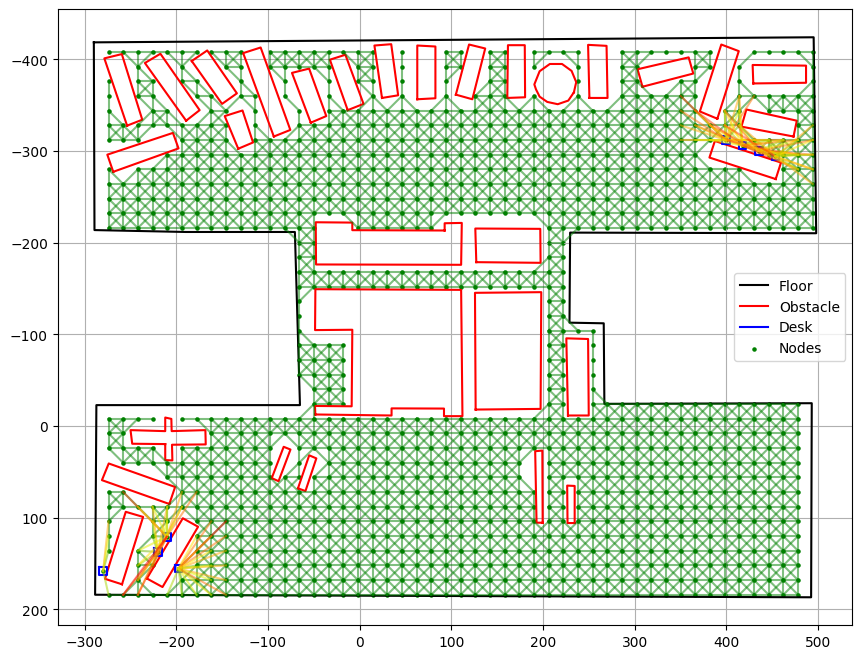

In [774]:
# Then you can use your existing plotting function
plot_walkability_graph(floor, obstacles, [desk[0] for desk in desks], nodes, edges)

In [775]:
def export_to_pgrouting(nodes, edges, floor, desks, obstacles, schema_name='public', table_prefix='route'):
    """
    Export nodes, edges, and floor plan elements to PostGIS/pgRouting tables.

    Args:
        nodes (list): List of shapely Points
        edges (list): List of (start_point, end_point) tuples
        floor (Polygon): Floor boundary polygon
        desks (list): List of (desk_polygon, desk_id) tuples
        obstacles (list): List of obstacle polygons
        schema_name (str): Database schema name
        table_prefix (str): Prefix for the tables
    """
    import psycopg2
    from psycopg2.extras import execute_values

    conn_params = {
        "dbname": "floorplan",
        "user": "postgres",
        "password": "postgres",
        "host": "localhost",
        "port": "5432"
    }

    SRID = 0
    try:
        conn = psycopg2.connect(**conn_params)
        cur = conn.cursor()

        # Create floor table
        cur.execute(f"""
        DROP TABLE IF EXISTS {schema_name}.{table_prefix}_floors CASCADE;
        CREATE TABLE {schema_name}.{table_prefix}_floors (
            id SERIAL PRIMARY KEY,
            name VARCHAR(50),
            geom geometry(Polygon, {SRID})
        );
        """)

        # Create desks table
        cur.execute(f"""
        DROP TABLE IF EXISTS {schema_name}.{table_prefix}_desks CASCADE;
        CREATE TABLE {schema_name}.{table_prefix}_desks (
            id SERIAL PRIMARY KEY,
            desk_id VARCHAR(50),
            floor_id INTEGER REFERENCES {schema_name}.{table_prefix}_floors(id),
            geom geometry(Polygon, {SRID})
        );
        """)

        # Create obstacles table
        cur.execute(f"""
        DROP TABLE IF EXISTS {schema_name}.{table_prefix}_obstacles CASCADE;
        CREATE TABLE {schema_name}.{table_prefix}_obstacles (
            id SERIAL PRIMARY KEY,
            floor_id INTEGER REFERENCES {schema_name}.{table_prefix}_floors(id),
            geom geometry(Polygon, {SRID})
        );
        """)

        # Create vertices and edges tables
        cur.execute(f"""
        DROP TABLE IF EXISTS {schema_name}.{table_prefix}_vertices CASCADE;
        CREATE TABLE {schema_name}.{table_prefix}_vertices (
            id SERIAL PRIMARY KEY,
            geom geometry(Point, {SRID})
        );

        DROP TABLE IF EXISTS {schema_name}.{table_prefix}_edges CASCADE;
        CREATE TABLE {schema_name}.{table_prefix}_edges (
            id SERIAL PRIMARY KEY,
            source INTEGER,
            target INTEGER,
            cost FLOAT,
            reverse_cost FLOAT,
            geom geometry(LineString, {SRID}),
            CONSTRAINT {table_prefix}_edges_source_fkey FOREIGN KEY (source)
                REFERENCES {schema_name}.{table_prefix}_vertices (id),
            CONSTRAINT {table_prefix}_edges_target_fkey FOREIGN KEY (target)
                REFERENCES {schema_name}.{table_prefix}_vertices (id)
        );
        """)

        # Insert floor
        floor_coords = ", ".join([f"{x} {y}" for x, y in floor.exterior.coords])
        cur.execute(f"""
        INSERT INTO {schema_name}.{table_prefix}_floors (name, geom)
        VALUES ('main', ST_GeomFromText('POLYGON(({floor_coords}))', {SRID}))
        RETURNING id;
        """)
        floor_id = cur.fetchone()[0]

        # Insert desks
        desk_sql = f"""
        INSERT INTO {schema_name}.{table_prefix}_desks (desk_id, floor_id, geom)
        VALUES %s
        """
        desk_data = []
        for desk_poly, desk_id in desks:
            coords = ", ".join([f"{x} {y}" for x, y in desk_poly.exterior.coords])
            desk_data.append((
                desk_id,
                floor_id,
                f"POLYGON(({coords}))"
            ))
        execute_values(cur, desk_sql, desk_data)

        # Insert obstacles
        obstacle_sql = f"""
        INSERT INTO {schema_name}.{table_prefix}_obstacles (floor_id, geom)
        VALUES %s
        """
        obstacle_data = []
        for obs_poly in obstacles:
            coords = ", ".join([f"{x} {y}" for x, y in obs_poly.exterior.coords])
            obstacle_data.append((
                floor_id,
                f"POLYGON(({coords}))"
            ))
        execute_values(cur, obstacle_sql, obstacle_data)

        # Insert vertices
        vertex_sql = f"INSERT INTO {schema_name}.{table_prefix}_vertices (geom) VALUES %s RETURNING id"
        vertex_data = [(f"POINT({node.x} {node.y})",) for node in nodes]
        vertex_ids = execute_values(cur, vertex_sql, vertex_data, fetch=True)

        # Create vertex lookup dictionary
        vertex_lookup = {str(nodes[i]): vertex_ids[i][0] for i in range(len(nodes))}

        # Insert edges
        edge_sql = f"""
        INSERT INTO {schema_name}.{table_prefix}_edges
        (source, target, cost, reverse_cost, geom) VALUES %s
        """
        edge_data = []
        for start, end, cost in edges:  # Note the added cost parameter
            source_id = vertex_lookup[str(start)]
            target_id = vertex_lookup[str(end)]
            edge_data.append((
                source_id,
                target_id,
                cost,  # Use the calculated cost instead of distance
                cost,  # Same cost for reverse direction
                f"LINESTRING({start.x} {start.y}, {end.x} {end.y})"
            ))
        execute_values(cur, edge_sql, edge_data)

        # Create spatial indexes
        cur.execute(f"""
        CREATE INDEX {table_prefix}_floors_geom_idx ON {schema_name}.{table_prefix}_floors USING GIST (geom);
        CREATE INDEX {table_prefix}_desks_geom_idx ON {schema_name}.{table_prefix}_desks USING GIST (geom);
        CREATE INDEX {table_prefix}_obstacles_geom_idx ON {schema_name}.{table_prefix}_obstacles USING GIST (geom);
        CREATE INDEX {table_prefix}_vertices_geom_idx ON {schema_name}.{table_prefix}_vertices USING GIST (geom);
        CREATE INDEX {table_prefix}_edges_geom_idx ON {schema_name}.{table_prefix}_edges USING GIST (geom);
        """)

        # Add pgRouting topology
        cur.execute(f"""
        SELECT pgr_createTopology(
            '{schema_name}.{table_prefix}_edges',
            0.0001,
            'geom',
            'id',
            'source',
            'target'
        );
        """)

        conn.commit()
        print("Successfully exported to pgRouting with floor plan elements!")

    except Exception as e:
        print(f"Error: {str(e)}")
        conn.rollback()
    finally:
        cur.close()
        conn.close()

In [776]:
export_to_pgrouting(nodes, edges, floor, desks, obstacles)

Successfully exported to pgRouting with floor plan elements!


In [777]:
def find_route_between_desks(source_id, destination_id, schema_name='public', table_prefix='route',
                             smooth_iterations=3):
    """
    Find the shortest route between two desks using their IDs.

    Args:
        source_id (str): ID of the source desk
        destination_id (str): ID of the destination desk
        schema_name (str): Database schema name
        table_prefix (str): Prefix for the tables
        smooth_iterations (int): Number of smoothing iterations (more iterations = smoother path)

    Returns:
        list: List of coordinates representing the path
    """
    import psycopg2
    from psycopg2.extras import RealDictCursor

    conn_params = {
        "dbname": "floorplan",
        "user": "postgres",
        "password": "postgres",
        "host": "localhost",
        "port": "5432"
    }

    try:
        conn = psycopg2.connect(**conn_params)
        cur = conn.cursor(cursor_factory=RealDictCursor)

        # Find the closest vertices to source and destination desks
        cur.execute(f"""
        WITH source_desk AS (
            SELECT ST_Centroid(geom) as geom
            FROM {schema_name}.{table_prefix}_desks
            WHERE desk_id = %s
        ),
        dest_desk AS (
            SELECT ST_Centroid(geom) as geom
            FROM {schema_name}.{table_prefix}_desks
            WHERE desk_id = %s
        ),
        source_vertex AS (
            SELECT v.id as source_id
            FROM {schema_name}.{table_prefix}_vertices v, source_desk s
            ORDER BY v.geom <-> s.geom
            LIMIT 1
        ),
        dest_vertex AS (
            SELECT v.id as target_id
            FROM {schema_name}.{table_prefix}_vertices v, dest_desk d
            ORDER BY v.geom <-> d.geom
            LIMIT 1
        )
        SELECT
            source_id,
            target_id,
            (SELECT ST_AsText(geom) FROM source_desk) as source_point,
            (SELECT ST_AsText(geom) FROM dest_desk) as dest_point
        FROM source_vertex, dest_vertex;
        """, (source_id, destination_id))

        vertex_info = cur.fetchone()

        if not vertex_info:
            raise Exception("Could not find source or destination desk")

        # Modified path query with smoothing
        cur.execute(f"""
        WITH path AS (
            SELECT ST_MakeLine(pt.geom ORDER BY di.seq) as path_geom
            FROM pgr_dijkstra(
                'SELECT id, source, target, cost FROM {schema_name}.{table_prefix}_edges',
                %s,
                %s,
                directed := false
            ) AS di
            JOIN {schema_name}.{table_prefix}_vertices AS pt
            ON di.node = pt.id
        )
        SELECT ST_AsText(
            ST_ChaikinSmoothing(
                path_geom,
                {smooth_iterations}  -- Number of iterations
            )
        ) as smooth_path
        FROM path;
        """, (vertex_info['source_id'], vertex_info['target_id']))

        result = cur.fetchone()

        if not result or not result['smooth_path']:
            raise Exception("No path found between the specified desks")

        # Convert the path to coordinates
        path_coords = []

        # Add source desk centroid
        source_point = vertex_info['source_point']
        if source_point:
            path_coords.append(_parse_point_text(source_point))

        # Parse the smoothed linestring
        smooth_coords = _parse_linestring_text(result['smooth_path'])
        path_coords.extend(smooth_coords)

        # Add destination desk centroid
        dest_point = vertex_info['dest_point']
        if dest_point:
            path_coords.append(_parse_point_text(dest_point))

        return path_coords

    except Exception as e:
        print(f"Error finding route: {str(e)}")
        return None
    finally:
        cur.close()
        conn.close()


def _parse_linestring_text(linestring_text):
    """Helper function to parse linestring text from PostGIS"""
    import re
    coords_text = linestring_text.replace('LINESTRING(', '').replace(')', '')
    coord_pairs = coords_text.split(',')
    coords = []
    for pair in coord_pairs:
        x, y = pair.strip().split()
        coords.append((float(x), float(y)))
    return coords


def _parse_point_text(point_text):
    """Helper function to parse point text from PostGIS"""
    import re
    coords = re.findall(r'-?[0-9]*\.?[0-9]+', point_text)
    return (float(coords[0]), float(coords[1]))


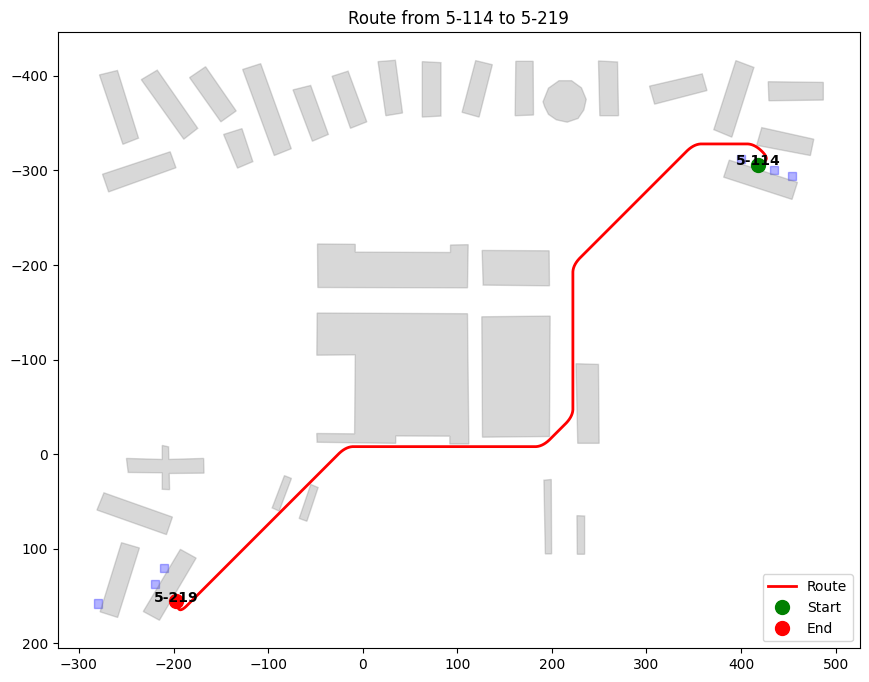

In [780]:

SOURCE = '5-114'
DESTINATION = '5-219'

# Calculate and plot the route
route_coords = find_route_between_desks(SOURCE, DESTINATION, smooth_iterations=3)

if route_coords:
    # Plot everything as before
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot desks
    for desk, desk_id in desks:
        x, y = desk.exterior.xy
        ax.fill(x, y, color='blue', alpha=0.3)
        if desk_id and (desk_id == SOURCE or desk_id == DESTINATION):
            ax.text(desk.centroid.x, desk.centroid.y - 4, desk_id, fontsize=10, ha='center', va='center', weight='bold')

    # Plot obstacles
    for poly in obstacles:
        x, y = poly.exterior.xy
        ax.fill(x, y, color='gray', alpha=0.3)

    # Plot the route
    route_x, route_y = zip(*route_coords)
    ax.plot(route_x, route_y, 'r-', linewidth=2, label='Route')

    # Highlight start and end points
    ax.plot(route_x[0], route_y[0], 'go', markersize=10, label='Start')
    ax.plot(route_x[-1], route_y[-1], 'ro', markersize=10, label='End')

    ax.set_title(f"Route from {SOURCE} to {DESTINATION}")
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(False)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Could not find a route between the specified desks")
